# Mapping problem using moscot  
from dissociated scRNAseq data (tosti) to spatial data 

### Import packages

In [ ]:
!pip install decoupler

In [ ]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [3]:
adata_sc = sc.read('/lustre/groups/ml01/workspace/hpca_sara.jimenez_shrey.parikh/initial_data/charite_snRNA/h5ad_file/adult_pancreas_2020.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 112563 × 43815
     obs: 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'patient_ID', 'sex', 'age', 'pancreas_location', 'procurement_lab', 'Cluster'
     var: 'name'
     obsm: 'X_pca', 'X_umap',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_

In [ ]:
adata_sc.X.max()

In [ ]:
adata_sc.raw

In [ ]:
adata_sc.layers['counts'].max()

In [ ]:
adata_sc.layers['soupX_counts'].max()

In [ ]:
adata_sc.var_names

In [ ]:
adata_s1.layers['counts'].max()

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [4]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [5]:
adata_sp.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

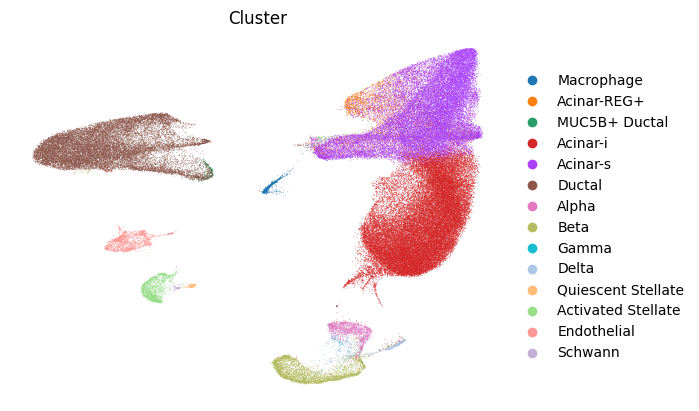

In [6]:
sc.pl.umap(adata_sc, color='Cluster',frameon=False)

In [7]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=10000,
    subset=True,
    #layer='counts',
    batch_key='sample_ID'
)
adata_sc

AnnData object with n_obs × n_vars = 112563 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'patient_ID', 'sex', 'age', 'pancreas_location', 'procurement_lab', 'Cluster'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Cluster_colors', 'hvg'
    obsm: 'X_pca', 'X_umap'

Pseudobulk dissociated data

In [8]:
import decoupler as dc

In [9]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='sample_ID',
    groups_col='Cluster',
    #layer='soupX_counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 213 × 8172
    obs: 'sample_ID', 'patient_ID', 'sex', 'age', 'pancreas_location', 'procurement_lab', 'Cluster', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    layers: 'psbulk_props'

In [10]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [14]:
adata_sc.obs['Cluster'].cat.categories

Index(['Macrophage', 'Acinar-REG+', 'MUC5B+ Ductal', 'Acinar-i', 'Acinar-s',
       'Ductal', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Quiescent Stellate',
       'Activated Stellate', 'Endothelial', 'Schwann'],
      dtype='object')

In [15]:
adata_sc.uns['Cluster_colors']

array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5'], dtype='<U7')

In [16]:
pdata.obs['Cluster'].cat.categories

Index(['Acinar-REG+', 'Acinar-i', 'Acinar-s', 'Activated Stellate', 'Alpha',
       'Beta', 'Delta', 'Ductal', 'Endothelial', 'Gamma', 'MUC5B+ Ductal',
       'Macrophage', 'Quiescent Stellate', 'Schwann'],
      dtype='object')

In [17]:
pdata.uns['Cluster_colors'] = [
    '#ff7f0e',#'Acinar-REG+'
    '#d62728',#'Acinar-i'
    '#aa40fc',#'Acinar-s'
    '#98df8a',#'Activated Stellate'
    '#e377c2',#'Alpha'
    '#b5bd61',#'Beta'
    '#aec7e8',#'Delta'
    '#8c564b',#'Ductal'
    '#ff9896',#'Endothelial'
    '#17becf',#'Gamma'
    '#279e68',#'MUC5B+ Ductal'
    '#1f77b4',#'Macrophage'
    '#ffbb78',#'Quiescent Stellate'
    '#c5b0d5',#'Schwann'
]

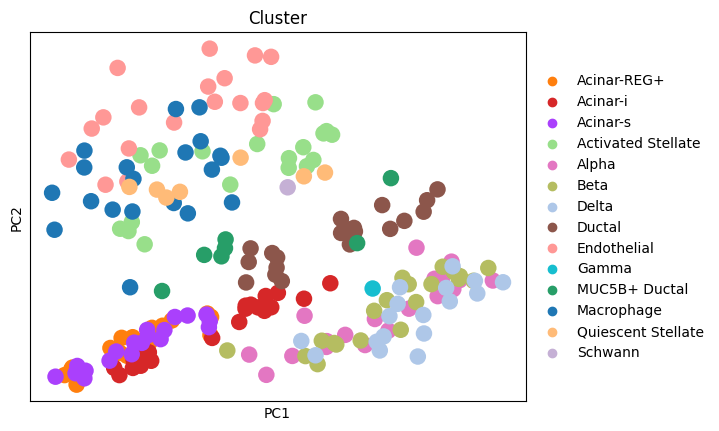

In [18]:
sc.pl.pca(pdata, color=['Cluster'])

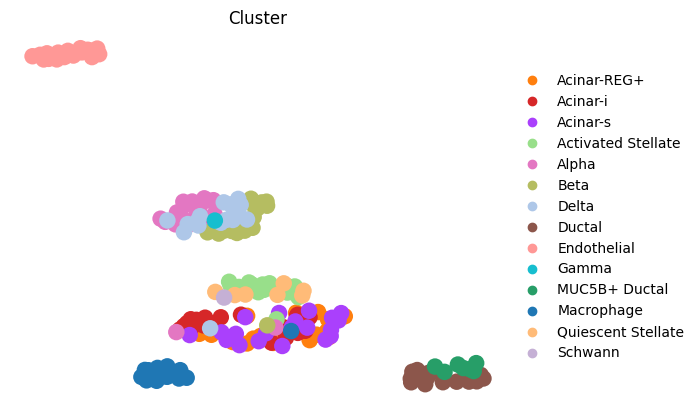

In [19]:
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)
sc.pl.umap(pdata, color='Cluster', frameon=False)

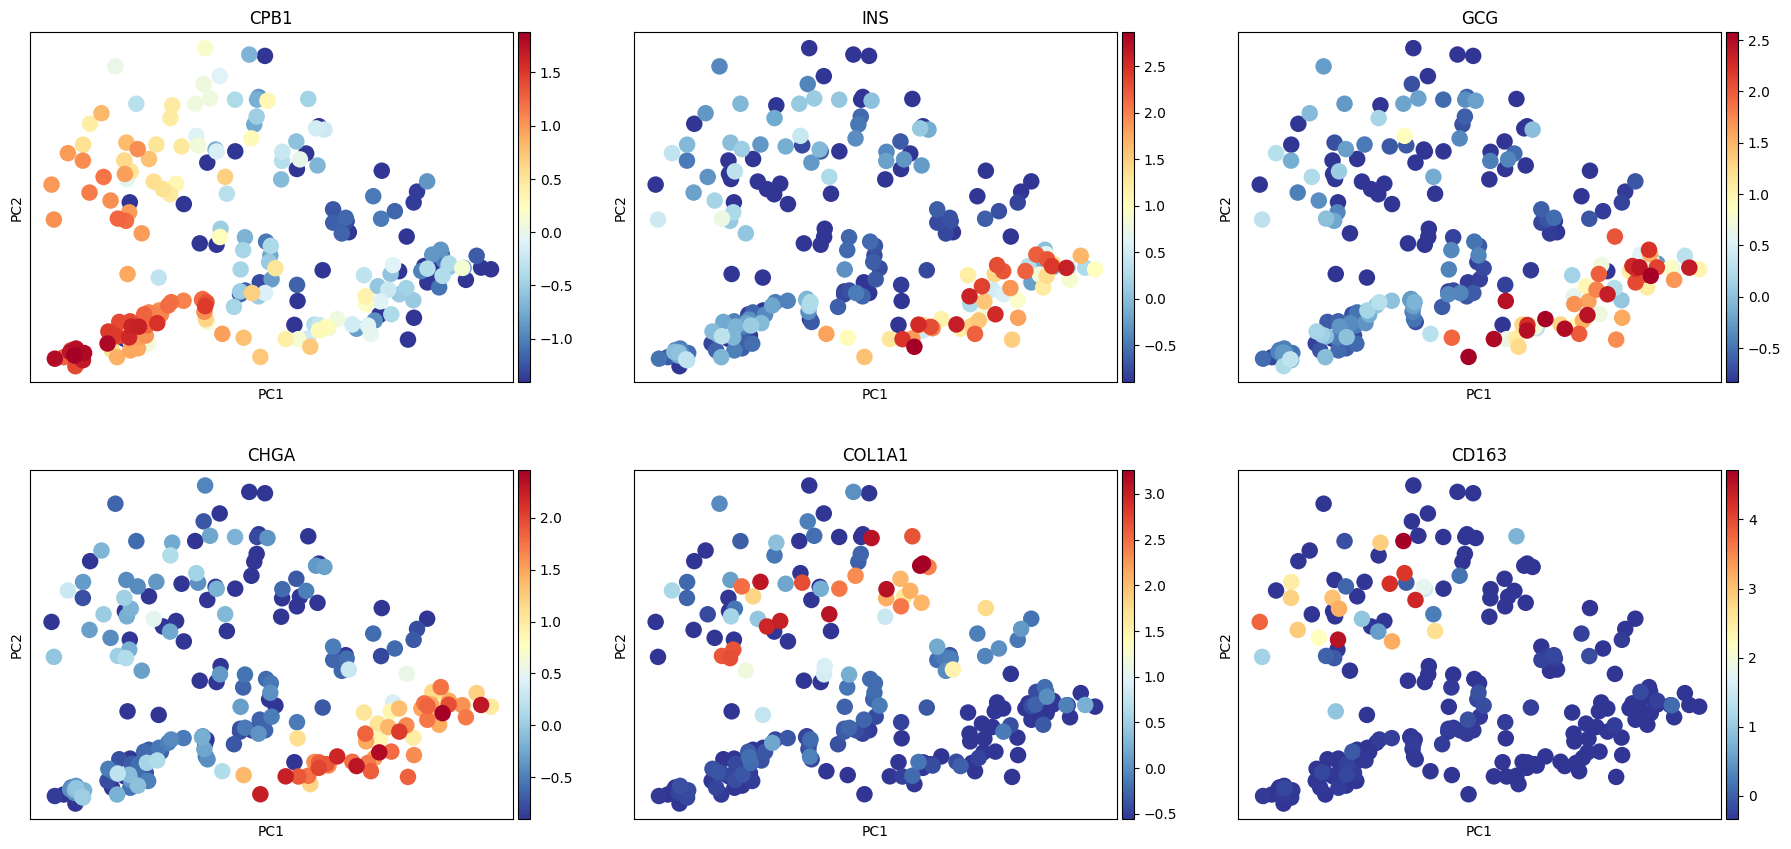

In [20]:
# 'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
sc.pl.pca(pdata,color=['CPB1', 'INS', 'GCG', 'CHGA', 'COL1A1', 'CD163'],
          ncols=3,cmap='RdYlBu_r')

Subset to a field of view to test the mapping problem 

In [21]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [22]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)

Normalization to avoid technical artifacts (has to be per fov)

In [ ]:
spatial = adata_sp_fov_12.obsm['spatial']
adata_sp_fov_12.obsm['spatial_norm'] = spatial - spatial.mean() / spatial.std()
adata_sp_fov_12.obsm['PCA_spatial'] = np.concatenate([adata_sp_fov_12.obsm['spatial_norm'], adata_sp_fov_12.obsm['X_pca']], axis = 1)

### Preprare and solve the mapping problem 

In [23]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [24]:
markers2impute

['CPB1', 'INS', 'GCG', 'CHGA', 'COL1A1', 'CD163']

In [25]:
# Leave the control genes out of the fitting
adata_sp_fov_12_mp = adata_sp_fov_12[:,~adata_sp_fov_12.var_names.isin(markers2impute)].copy()

In [26]:
params = {
    'epsilon': [0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [27]:
from sklearn.metrics import f1_score

In [28]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_sp_fov_12_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'} #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df = pd.DataFrame(evaluation)
df

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


2024-07-21 16:00:13.606799: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].

/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3873715/55960364.py:28: ConstantInputWar

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           
WARNING  Solver did not converge                                                                                   


tau_a  tau_b  alpha  epsilon  cpb1_corr  ins_corr  gcg_corr  chga_corr  \
0    0.999  0.999    0.2     0.01   0.188953  0.444377  0.460096   0.511210   
1    0.999  0.999    0.2     0.05   0.231123  0.541943  0.558506   0.599728   
2    0.999  0.999    0.2     0.10   0.272086  0.629789  0.638603   0.662843   
3    0.999  0.999    0.3     0.01   0.245880  0.497406  0.538988   0.588698   
4    0.999  0.999    0.3     0.05   0.320739  0.658985  0.689562   0.711830   
..     ...    ...    ...      ...        ...       ...       ...        ...   
187  0.900  0.900    0.4     0.05        NaN       NaN       NaN        NaN   
188  0.900  0.900    0.4     0.10   0.630156  0.757298  0.769199   0.768245   
189  0.900  0.900    0.5     0.01        NaN       NaN       NaN        NaN   
190  0.900  0.900    0.5     0.05   0.639833  0.822708  0.858569   0.843353   
191  0.900  0.900    0.5     0.10   0.719244  0.761433  0.770819   0.764110   

     col1a1_corr  cd163_corr  mean_corr  
0       0.228232    0.219149   0.342003  
1       0.267497    0.271934   0.411789  
2       0.321416    0.357900   0.480439  
3       0.232700    0.225213   0.388147  
4       0.300173    0.325139   0.501071  
..           ...         ...        ...  
187          NaN         NaN        NaN  
188     0.372160    0.434223   0.621880  
189          NaN         NaN        NaN  
190     0.302366    0.287289   0.625686  
191     0.367298    0.422319   0.634204  

[192 rows x 11 columns]

In [29]:
# Find the index label corresponding to the maximum value in a specific column
max_index = df['mean_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values = df.loc[max_index]

# Print the values
print(max_row_values)

tau_a          0.990000
tau_b          0.900000
alpha          0.500000
epsilon        0.100000
cpb1_corr      0.648231
ins_corr       0.778537
gcg_corr       0.797601
chga_corr      0.793871
col1a1_corr    0.368468
cd163_corr     0.422341
mean_corr      0.634842
Name: 143, dtype: float64


### Analysis of the transport plan with the best set of found parameters

In [30]:
best_param = max_row_values.to_dict()
best_param

{'tau_a': 0.99,
 'tau_b': 0.9,
 'alpha': 0.5,
 'epsilon': 0.1,
 'cpb1_corr': 0.6482309831344503,
 'ins_corr': 0.7785374289994795,
 'gcg_corr': 0.7976006834187277,
 'chga_corr': 0.7938707566997047,
 'col1a1_corr': 0.36846802767001974,
 'cd163_corr': 0.4223413910861511,
 'mean_corr': 0.6348415451680888}

In [31]:
mp = MappingProblem(adata_sc=pdata, adata_sp=adata_sp_fov_12_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 213)].                                           


#### Imputation

In [32]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed = mp.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 12.841719388961792 seconds


In [33]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 8160

In [34]:
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [35]:
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 8160
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [36]:
markers2impute

['CPB1', 'INS', 'GCG', 'CHGA', 'COL1A1', 'CD163']

In [37]:
correlations_hallmark_genes = []

for i in markers2impute:
    gene = i
    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
    correlation, p_value = pearsonr(obs_genes, imp_genes)
    row_data = {
        'gene' : gene,
        'Pearson_correlation' : correlation,
        'P_value' : p_value
    }
    correlations_hallmark_genes.append(row_data)
                
df = pd.DataFrame(correlations_hallmark_genes)
df

gene  Pearson_correlation        P_value
0    CPB1             0.648231   0.000000e+00
1     INS             0.778537   0.000000e+00
2     GCG             0.797601   0.000000e+00
3    CHGA             0.793871   0.000000e+00
4  COL1A1             0.368468  3.346737e-167
5   CD163             0.422341  2.074444e-224

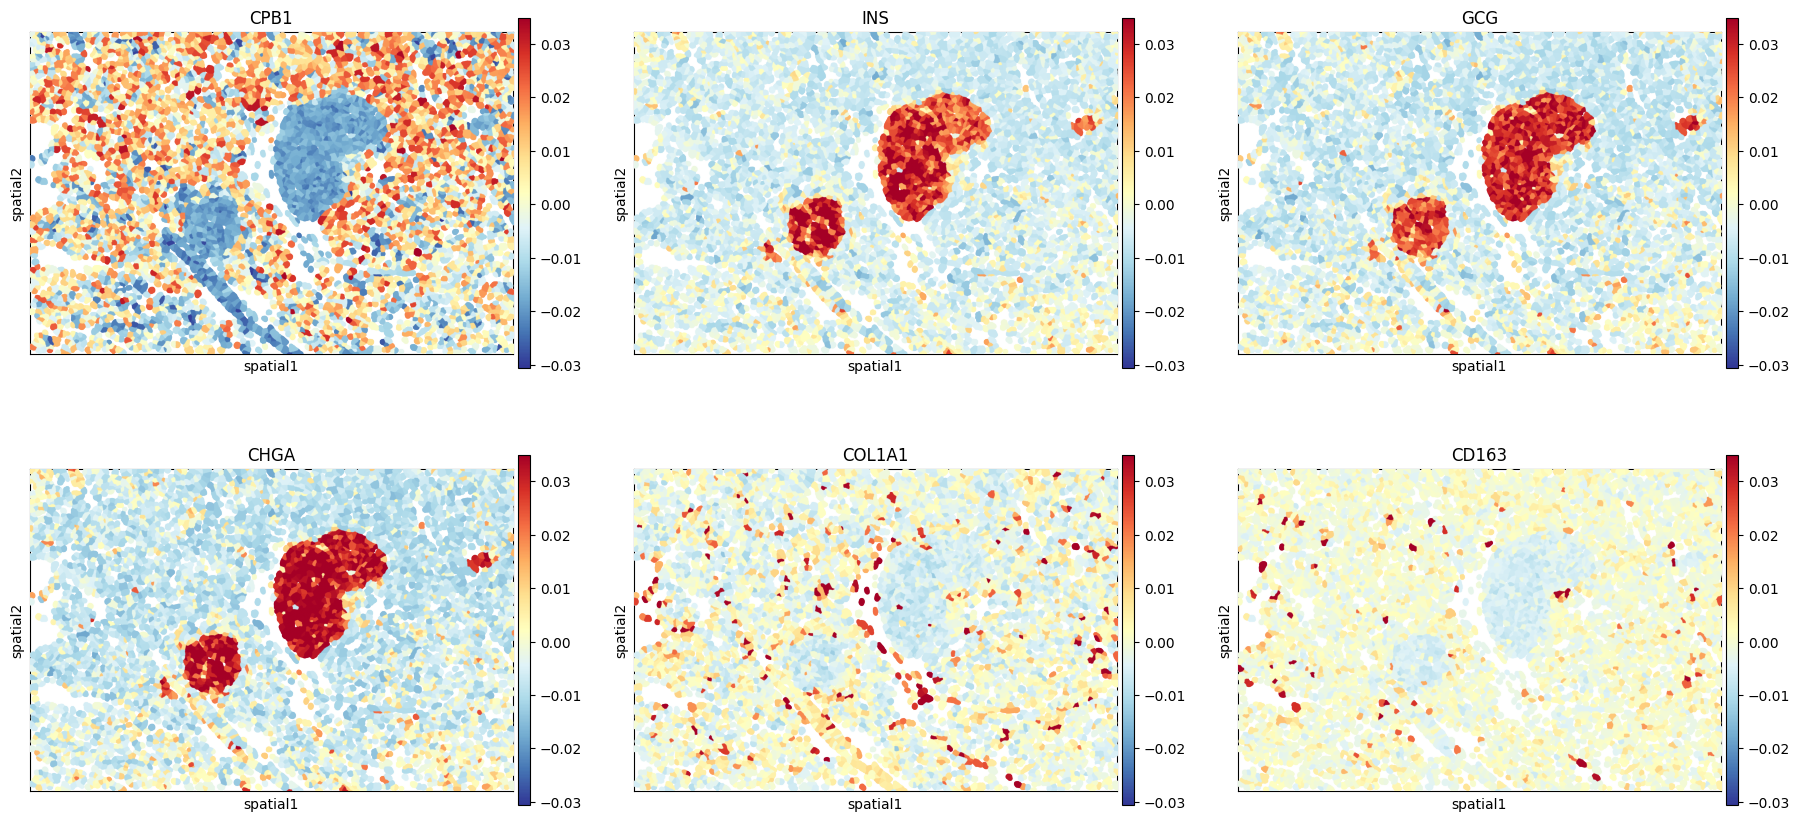

In [38]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [39]:
adata_sp_fov_12, adata_imputed

(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivit

#### Annotation mapping

In [40]:
mp[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 213)]

In [41]:
type(pdata.obs.Cluster)

pandas.core.series.Series

In [42]:
pdata.obs.cell_type = pdata.obs.Cluster.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

Annotation mapping using “max” mode

In [43]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "Cluster",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 3.403303623199463 seconds


In [44]:
adata_sp_fov_12.obs["Cluster_max"] = anno_map_max["Cluster"].values
adata_sp_fov_12.obs["Cluster_max"] = adata_sp_fov_12.obs["Cluster_max"].astype("category")

In [46]:
adata_sp_fov_12.uns['Cluster_max_colors'] = [
    '#ff7f0e',#'Acinar-REG+'
    '#d62728',#'Acinar-i'
    '#aa40fc',#'Acinar-s'
    '#98df8a',#'Activated Stellate'
    '#e377c2',#'Alpha'
    '#b5bd61',#'Beta'
    '#aec7e8',#'Delta'
    '#8c564b',#'Ductal'
    '#ff9896',#'Endothelial'
    '#17becf',#'Gamma'
    '#279e68',#'MUC5B+ Ductal'
    '#1f77b4',#'Macrophage'
    '#ffbb78',#'Quiescent Stellate'
    '#c5b0d5',#'Schwann'
]

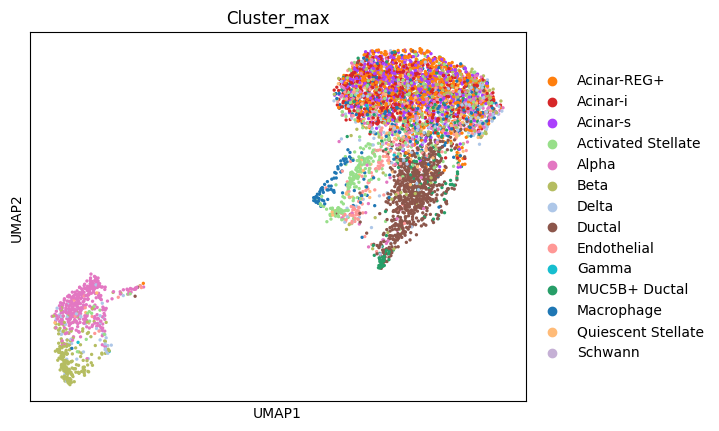

In [47]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_12, color=["Cluster_max"])

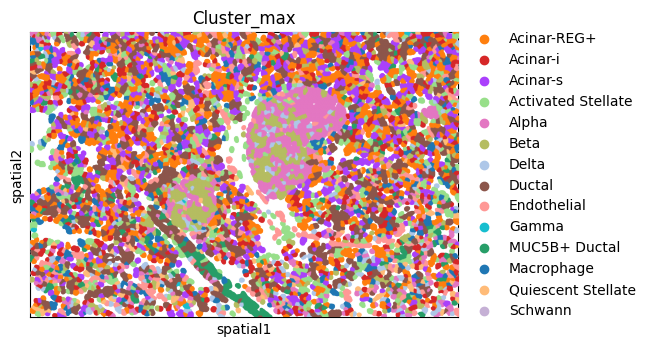

In [48]:
sq.pl.spatial_segment(adata_sp_fov_12,color='Cluster_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Annotation mapping using the “sum” mode

In [49]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "Cluster",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp_fov_12.obs["Cluster_sum"] = anno_map_sum["Cluster"].values
adata_sp_fov_12.obs["Cluster_sum"] = adata_sp_fov_12.obs["Cluster_sum"].astype("category")

In [52]:
adata_sp_fov_12.uns['Cluster_sum_colors'] = [
    '#ff7f0e',#'Acinar-REG+'
    '#d62728',#'Acinar-i'
    '#aa40fc',#'Acinar-s'
    '#98df8a',#'Activated Stellate'
    '#e377c2',#'Alpha'
    '#b5bd61',#'Beta'
    '#aec7e8',#'Delta'
    '#8c564b',#'Ductal'
    '#ff9896',#'Endothelial'
    #'#17becf',#'Gamma'
    '#279e68',#'MUC5B+ Ductal'
    '#1f77b4',#'Macrophage'
    #'#ffbb78',#'Quiescent Stellate'
    #'#c5b0d5',#'Schwann'
]

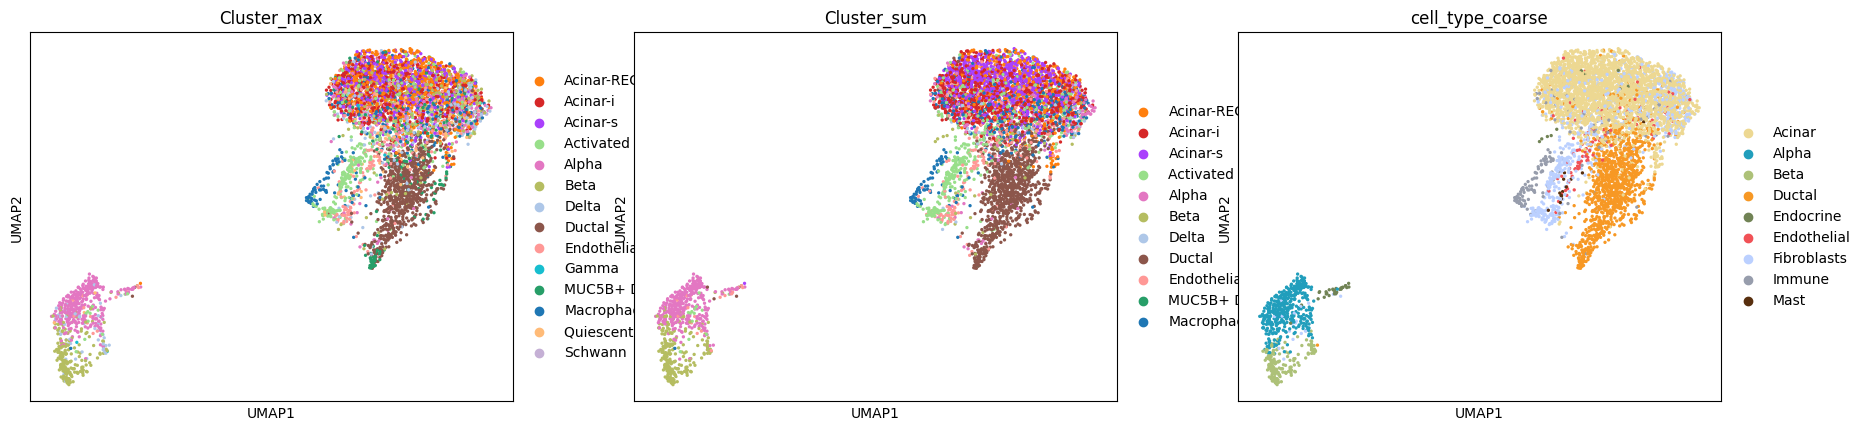

In [53]:
sc.pl.umap(adata_sp_fov_12, color=["Cluster_max", "Cluster_sum","cell_type_coarse"])

In [54]:
adata_sp_fov_12_cmp = adata_sp_fov_12[~adata_sp_fov_12.obs.Cluster_max.isin(['Gamma','Schwann','Quiescent Stellate']),:].copy()
adata_sp_fov_12_cmp

AnnData object with n_obs × n_vars = 5057 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'Cluster_max', 'Cluster_sum'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'Cluster_max_colors', 'Cluster_sum_colors'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    va

In [55]:
adata_sp_fov_12_cmp[adata_sp_fov_12_cmp.obs["Cluster_max"] == adata_sp_fov_12_cmp.obs["Cluster_sum"]].shape[
    0
] / adata_sp_fov_12_cmp.shape[0]

0.6420802847538066

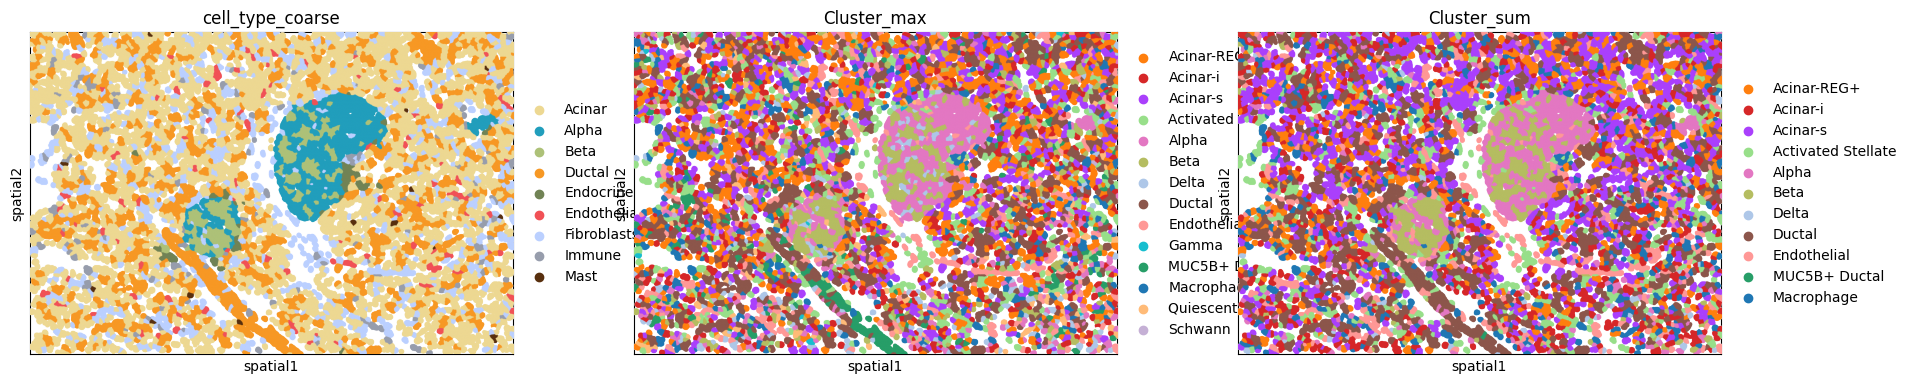

In [56]:
sq.pl.spatial_segment(adata_sp_fov_12,color=['cell_type_coarse','Cluster_max','Cluster_sum'],size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
sq.pl.spatial_segment(adata_sp_fov_12,color=['Cluster_max'],size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [63]:
adata_sp_fov_12.obs.Cluster_max.cat.categories

Index(['Acinar-REG+', 'Acinar-i', 'Acinar-s', 'Activated Stellate', 'Alpha',
       'Beta', 'Delta', 'Ductal', 'Endothelial', 'Gamma', 'MUC5B+ Ductal',
       'Macrophage', 'Quiescent Stellate', 'Schwann'],
      dtype='object')

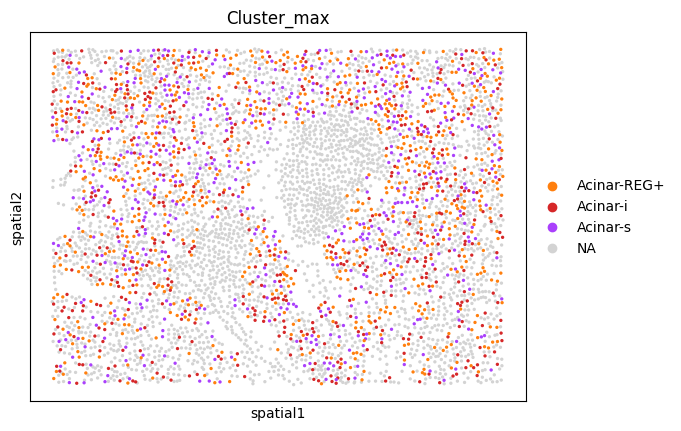

In [64]:
sc.pl.embedding(adata_sp_fov_12,color=['Cluster_max'],groups=['Acinar-REG+','Acinar-i','Acinar-s'],
                      basis='spatial')

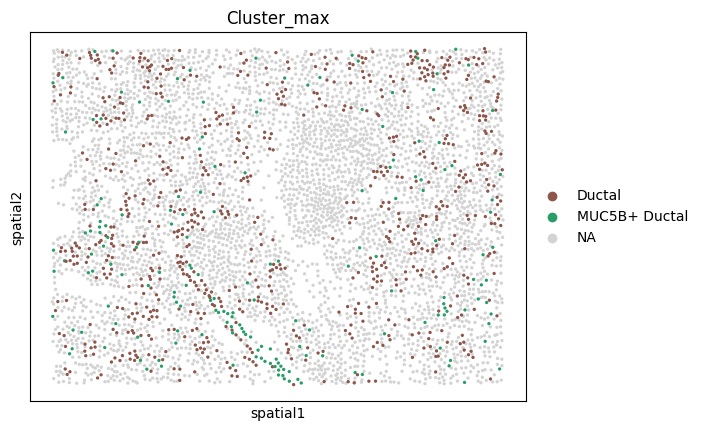

In [65]:
sc.pl.embedding(adata_sp_fov_12,color=['Cluster_max'],groups=['Ductal','MUC5B+ Ductal'],
                      basis='spatial')

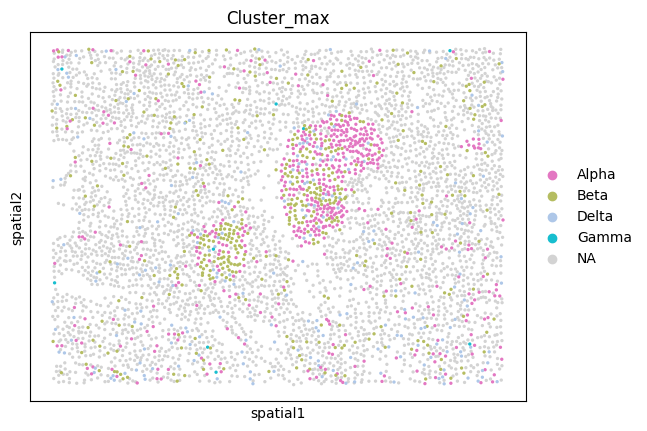

In [66]:
sc.pl.embedding(adata_sp_fov_12,color=['Cluster_max'],groups=['Alpha','Beta', 'Delta', 'Gamma'],
                      basis='spatial')

In [57]:
sq.gr.spatial_neighbors(
    adata_sp_fov_12,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

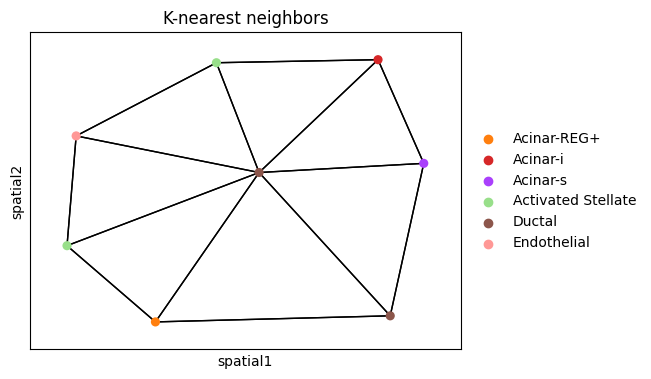

In [58]:
_, idx = adata_sp_fov_12.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata_sp_fov_12[idx,420],
    library_id = '12',
    color="Cluster_max",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [59]:
sq.gr.nhood_enrichment(adata_sp_fov_12,cluster_key='Cluster_max')

  0%|          | 0/1000 [00:00<?, ?/s]/home/aih/sara.jimenez/miniconda3/envs/moscot_v2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [00:01<00:00, 848.79/s]


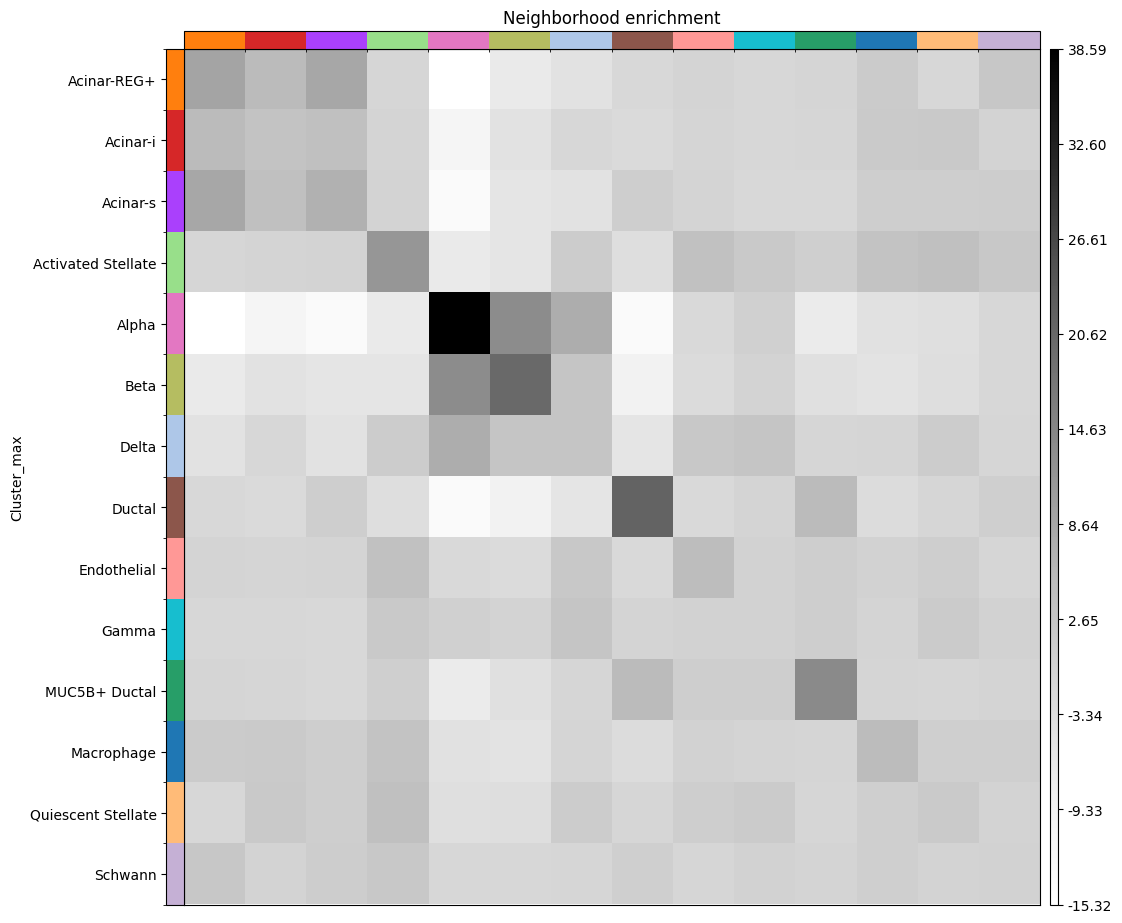

In [60]:
sq.pl.nhood_enrichment(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')

In [61]:
sq.gr.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',weights=True)

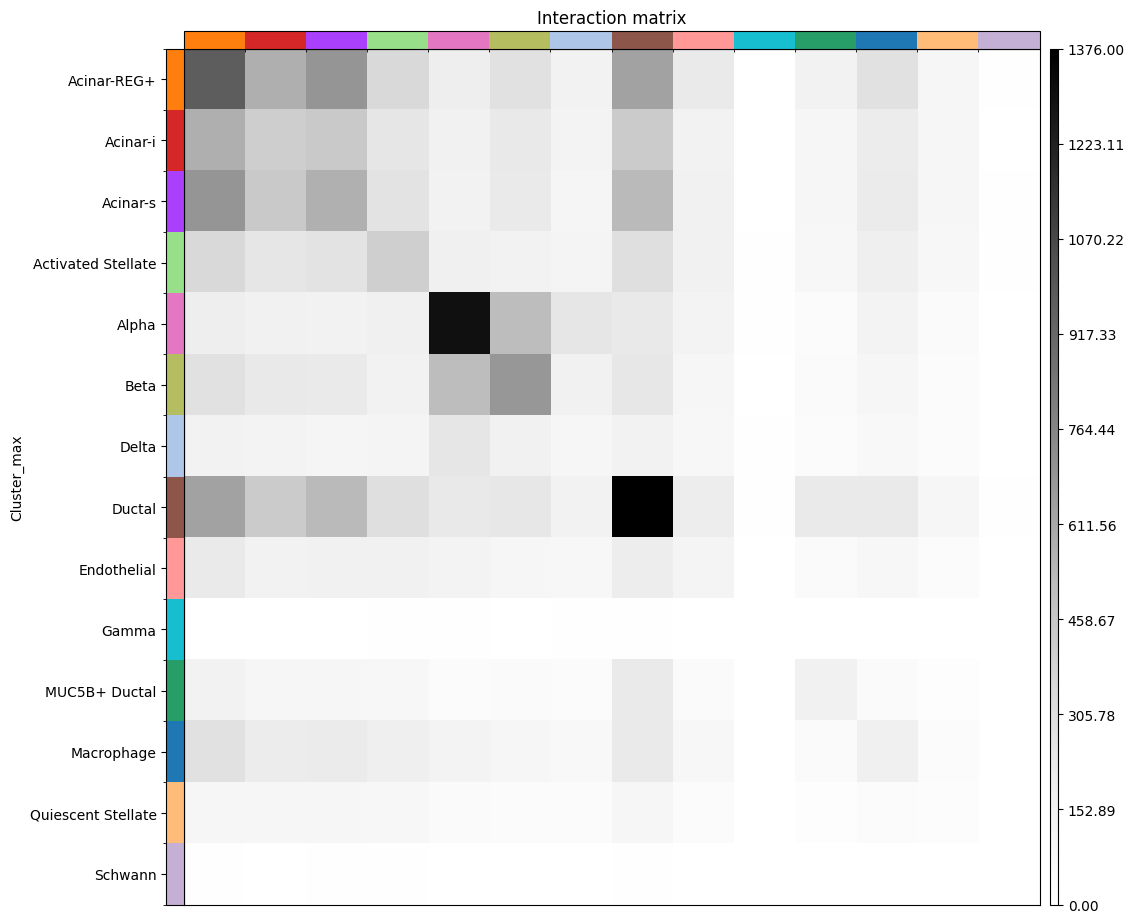

In [62]:
sq.pl.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')